In [1]:
import sys, os, time
import shutil

# %pdb

# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

# plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
# len(dataset)

In [3]:
# dataset = train.get_dataset('transfer', new='nocap-3dshapes', budget=100,
#                             new_kwargs={'dataroot':os.environ['FOUNDATION_DATA_DIR'], 'labels':False})
# len(dataset)

In [ ]:
# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0,10,0,10])

# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0, None, 0, 0])

dataset = train.get_dataset('transfer', dataroot=os.environ['FOUNDATION_DATA_DIR'], new='byfactor', old='byfactor', budget=100, old2new_ratio=1,
                             new_kwargs={
                                         'counts': [0, 100, 0, 0],
                                         'labels':False},
                             old_kwargs={
                                         'counts': [0, 0, None, 0],
                                        'labels':False})

len(dataset)

Loading dataset: transfer
budget: 100
old2new_ratio: 1


AttributeError: 'str' object has no attribute '_type'

In [ ]:
idx = np.random.randint(len(dataset), size=16)
idx

In [ ]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

In [2]:
M = Hybrid_Controller().filter_strs('!test')

Found 143 runs
Auto parsing failed with: test-cmd_200129-123106
Auto parsing failed with: test-cmd_200129-181621
Auto parsing failed with: test-cmd_200129-184754
Auto parsing failed with: test-cmd_200129-220436
Auto parsing failed with: test-cmd_200129-220823
Auto parsing failed with: test-cmd_200129-220851
Auto parsing failed with: test-cmd_200129-221006
Auto parsing failed with: test-cmd_200129-223408
Auto parsing failed with: test-cmd_200129-223445
Auto parsing failed with: test-cmd_200129-230209
Auto parsing failed with: test-cmd_200129-230317
Auto parsing failed with: test-cmd_200129-230424
Auto parsing failed with: test-cmd_200129-230534
Auto parsing failed with: test-cmd_200129-230658
Auto parsing failed with: test-cmd_200131-125233
Auto parsing failed with: test-cmd_200131-125639
Auto parsing failed with: test-cmd_200131-131602
Auto parsing failed with: test-cmd_200131-131825
Auto parsing failed with: test-cmd_200131-185027
Auto parsing failed with: test-pycharm_200129-191211
A

In [3]:
M.clear_run_cache()

In [89]:
M.clear_filters().filter_strs('!test')

# M.filter_datasets( 'redball', 'rgbball', '3dshapes')

# M.filter_since(date='200114').filter_data('rgbball')
# M.filter_jobs(157, 158)
# M.filter_jobs(169)
# M.filter_jobs(178)
# M.filter_jobs(174, 175)
# M.filter_models('vae')
# M.filter_jobs(94, 122) # basic models
# M.filter_jobs(100, 102)
# M.filter(lambda r: 'adain-dec' in r.config.info.history)
M.filter_models('fwae')

M.store_selection('all')

M.prep_info()

M.filter_datasets('3dSshape1', )#'3dSshape1s1', '3dSshape1s2')

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' not in r.config)

M.sort_by('date')

M.store_selection('originals')
print('originals', len(M))



M.switch_selection('all')

M.filter_datasets('3dSshape1s1', )

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' in r.config)

M.sort_by('date')

M.store_selection('stage1')

print('stage1', len(M))

M.switch_selection('all')

M.filter_datasets('3dSshape1s1', )

# M.filter_checkpoints(60)

M.filter(lambda r: 'loaded' not in r.config)

M.sort_by('date')

M.store_selection('ctrl')

print('ctrl', len(M))

# M.load_configs(60)

# M.load_configs(100)

# M.sort_by('job')

Selecting checkpoint: last
Loaded configs
originals 1
stage1 2
ctrl 1


In [90]:
group_names = ['originals', 'stage1', 'ctrl']
groups = {}

inds = None
if inds is None:
    inds = [None]*len(group_names)

runs = []

for g, i in zip(group_names, inds):
    M.switch_selection(g)
    if i is None:
        i = 0
    runs.append(M[i])
    groups[g] = M[i]
    runs[-1].stage = g
    print('{}: {}'.format(runs[-1].stage, runs[-1].name))

originals: 3dSshape1-fwae_0002-6026518-12_200129-002149
stage1: 3dSshape1s1-fwae_0016-6035183-02_200129-224937
ctrl: 3dSshape1s1-fwae_0021-6042295-02_200130-130723


In [91]:
# M.load_into('eval.pth.tar')

In [92]:
M.set_active(runs)
M.show('ckpt')

  0) 3dSshape1-fwae_0002-6026518-12_200129-002149
	Checkpoint: 32 (approx 96000 steps)

  1) 3dSshape1s1-fwae_0016-6035183-02_200129-224937
	Checkpoint: 37 (approx 74000 steps)

  2) 3dSshape1s1-fwae_0021-6042295-02_200130-130723
	Checkpoint: 50 (approx 100000 steps)



In [93]:
# full = trn.get_dataset('3dshapes')

In [147]:
box = trn.get_dataset('byfactor', counts=[-1,0,0,0])
cyl = trn.get_dataset('byfactor', counts=[0,1600,0,0])
sph = trn.get_dataset('byfactor', counts=[0,0,1600,0])
dataset = box

Loading dataset: byfactor
factor: shape (by default)
vals: None (by default)
counts: [-1, 0, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 287906/384000 samples
Loading dataset: byfactor
factor: shape (by default)
vals: None (by default)
counts: [0, 1600, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 382400/384000 samples
Loading dataset: byfactor
factor: shape (by default)
vals: None (by default)
counts: [0, 0, 1600, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fl

In [148]:

def _loadrun(run):
    
    state = run.reset()
    state.dataset = dataset

    run.load()

    del state.loader
    del state.batch
    del state.X

    return state
Ss = M.map(_loadrun)
S = Ss[0]
len(M)

/is/ei/fleeb/workspace/chome/trained_nets/3dSshape1-fwae_0002-6026518-12_200129-002149/checkpoint_32.pth.tar
True
load successful
Loaded /is/ei/fleeb/workspace/chome/trained_nets/3dSshape1-fwae_0002-6026518-12_200129-002149/checkpoint_32.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
factor: shape
vals: None (by default)
counts: [-1, 0, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fleeb/workspace/local_data (in parent)
load_memory: True (by default)
train: True
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 287906/384000 samples
Dataset moved to cpu
Model-type: fwpp
latent_disc: None (by default)
reg_prior: 0.1
ldisc_steps: 1 (by default)
ldisc_gp: 10.0 (by default)
Creating encoder (type=double-enc)
  in_shape --> din: (3, 64, 64) (in parent)
  channels: [64, 64, 64, 128, 128] (in parent)
  factors: 2 (in parent)
  internal_channels: [None, None, None, None, None]

Model on cuda
Loaded model_state from checkpoint
*** Using validation set
Found an existing dataset, len=96094, using that instead
Trained on 12.50 M samples
/is/ei/fleeb/workspace/chome/trained_nets/3dSshape1s1-fwae_0021-6042295-02_200130-130723/checkpoint_50.pth.tar
True
load successful
Loaded /is/ei/fleeb/workspace/chome/trained_nets/3dSshape1s1-fwae_0021-6042295-02_200130-130723/checkpoint_50.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
budget: 600
old2new_ratio: 1
Replaced counts in old: from [-1, 0, 0, 0] to [-1, 0, 0, 0]
Replaced counts in new: from [0, 600, 0, 0] to [0, 600, 0, 0]
Creating old (type=dataset/byfactor)
  factor: shape
  vals: None (by default)
  counts: [-1, 0, 0, 0]
  seeds: None (by default)
  det: True (by default)
  labeled: False (by default)
  dataroot: /is/ei/fleeb/workspace/local_data (in parent)
  load_memory: True (by default)
  train: True (in parent)
  labeled: True
  noise: None (by default)
  din: (3, 64, 64) (by default)
  dout: 6 (by

3

In [149]:
border, between = 0.02, 0.01

In [150]:
M[0].config.dataset

{{'batch_size':128, 'counts':[-1, 0, 0, 0], 'drop_last':False, 'factor':'shape', 'name':'byfactor', 'shuffle':True, 'val_split':0.1, '_ipython_canary_method_should_not_exist_':{{}}}}

In [159]:
dataset = cyl

In [160]:
dataset = fd.data.Subset_Dataset(dataset, np.arange(500)+1000)
len(dataset)

500

In [161]:
util.set_seed(0)
B = 16
idx = np.random.randint(len(dataset), size=(B,))
idx

array([172,  47, 117, 192, 323, 251, 195, 359,   9, 211, 277, 242, 292,  87,  70, 472])

In [162]:
X, = dataset[idx]
X = X.to('cuda')
B = X.size(0)
X.shape

torch.Size([16, 3, 64, 64])

<IPython.core.display.Javascript object>


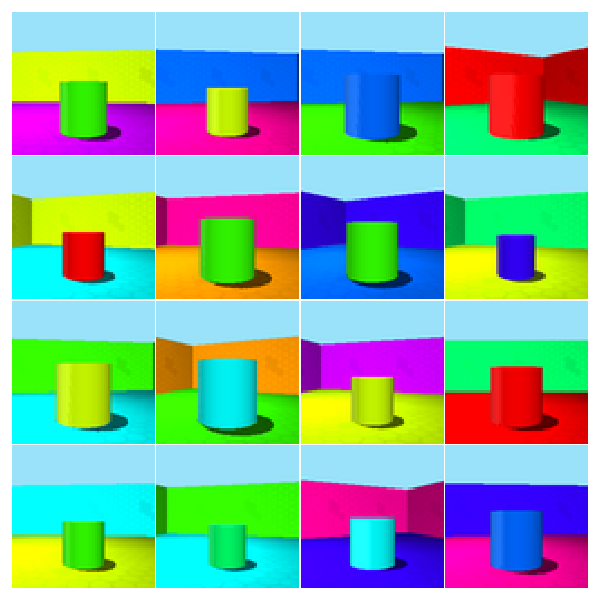

In [163]:
fig = show_nums(X)
plt.subplots_adjust(wspace=between, hspace=between,
	                    left=border, right=1 - border, bottom=border, top=1 - border)
pass

In [164]:
criterion = S.model.criterion
criterion.reduction = 'none'

In [165]:

def _fn(run):
    s = run.state
    with torch.no_grad():
        s.q = s.model.encode(X)
        s.rec = s.model.decode(s.q)
        loss = criterion(X, s.rec)
        s.loss = loss.view(B,-1).sum(-1)
        
    return s.rec

recs = M.map(_fn)

<IPython.core.display.Javascript object>


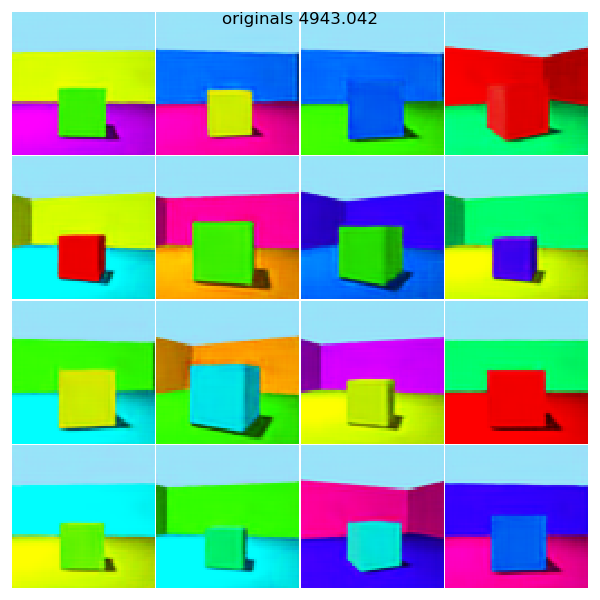

<IPython.core.display.Javascript object>


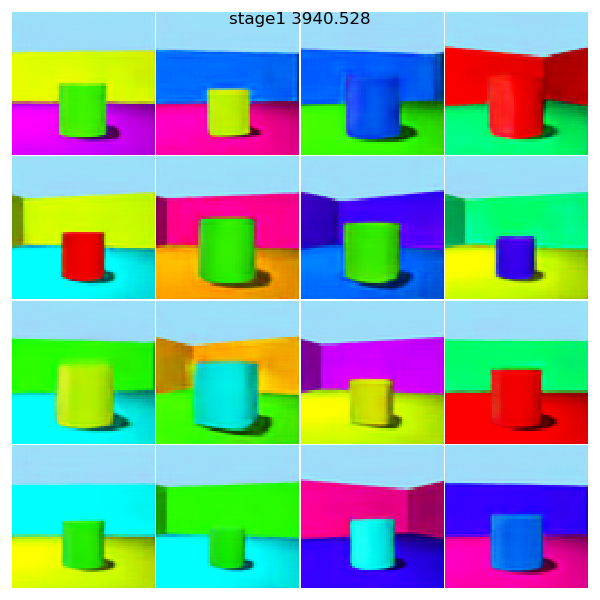

<IPython.core.display.Javascript object>


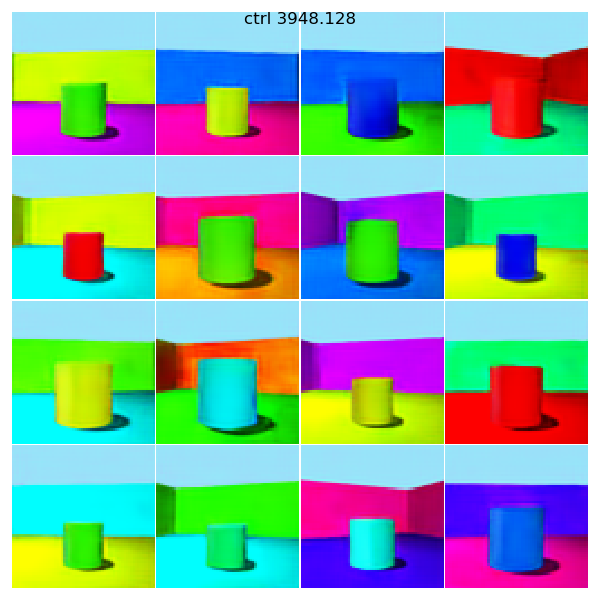

In [166]:
def _fn(run):
    s = run.state
    fig = show_nums(s.rec)
    fig.suptitle('{} {:.3f}'.format(run.stage, s.loss.mean().item()))q
    plt.subplots_adjust(wspace=between, hspace=between,
                            left=border, right=1 - border, bottom=border, top=1 - border)
    return fig
figs = M.map(_fn)

In [109]:
ref = groups['originals']
def _latent_dists(run):
    if run.stage != ref.stage:
        
        A = ref.state.q
        B = run.state.q
        
        dist = (A-B).norm(2,dim=-1)
        run.dist = dist
    
    else:
        run.dist = None

M.map(_latent_dists)
pass
        

In [113]:
groups, dists = M.through().stage, M.through().dist
groups = [g for d,g in zip(dists,groups) if d is not None]
dists = [d.cpu().numpy() for d,g in zip(dists,groups) if d is not None]

In [114]:

vals = np.concatenate(dists)
Xs = groups

inds = np.stack([Xs] * vals.shape[0])
df = pd.DataFrame({'x': inds.reshape(-1), 'y': vals.reshape(-1)})
# df['moment']='log(sigma)'

hue = None
split = False
color = 'C2'
inner = 'box'
palette = None

fig, ax = plt.subplots(figsize=(9, 3))
sns.violinplot(x='x', y='y', hue=hue,
               data=df, split=split, color=color, palette=palette,
               scale="count", inner=inner, gridsize=100)
plt.title('Intervention Effect on Image')
plt.xlabel('Dimension')

plt.ylabel('Effect')
plt.tight_layout()


fig = plt.figure()
plt.barplot()

ValueError: arrays must all be same length

In [9]:
run = M[11]
run.name

'3dSshape1s1-wae_0016-6035183-00_200129-223826'

In [10]:
run.meta.history

['n/t/box-s1', 'n/t/transfer-3ds']

In [ ]:
run.config.

In [28]:
S = run.reset()

In [29]:

S.dataset = dataset
len(S.dataset)

200

In [30]:
# S.A = train.get_config()
# S.A.dataset.kwargs = {'counts': [0, 128, 128, 0]}
# S.A.dataset.val_split = '__x__'

S.A.skip_precomputed = True
# S.A.use_train = True


# S.A.device = 'cpu'

KeyError: 'A'

In [10]:
# S.bounds = -2,2
run.load(pbar=tqdm)

/is/ei/fleeb/workspace/chome/trained_nets/cyl-wae_0178-6017981-00_200125-221552/checkpoint_397.pth.tar
True
load successful
Loaded /is/ei/fleeb/workspace/chome/trained_nets/cyl-wae_0178-6017981-00_200125-221552/checkpoint_397.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
name: byfactor
Filtering out 383744/384000 samples
Dataset byfactor moved to cpu
Dataset din=(3, 64, 64), dout=(3, 64, 64)
Model-type: wpp
encoder (type=double-enc): 
  in_shape --> din: (3, 64, 64) (by parent)
  channels: [64, 64, 64, 128, 128] (by parent)
  factors: 2 (by parent)
  internal_channels: [None, None, None, None, None] (by default)
  squeeze: [False, False, False, False, False] (by default)
  output_nonlin: None (by default)
  latent_dim: 12 (by parent)
  tail (type=nn): 
    input_dim --> din: (128, 2, 2)
    output_dim --> dout: 12
    hidden_dims: [256, 128]
    nonlin: elu (by parent)
    output_nonlin: None (by default)
  nonlin: elu (by parent)
  output_nonlin: None (by default)
  outpu

In [11]:
run.run(pbar=tqdm)

Using batched data loader
No validation set found


In [12]:
plt.ioff()
viz = run.visualize(tqdm)
len(viz), viz.keys()

(7,
 dict_keys(['original', 'recs', 'gens', 'hybrid', 'latent', 'effects', 'traversals']))

<IPython.core.display.Javascript object>


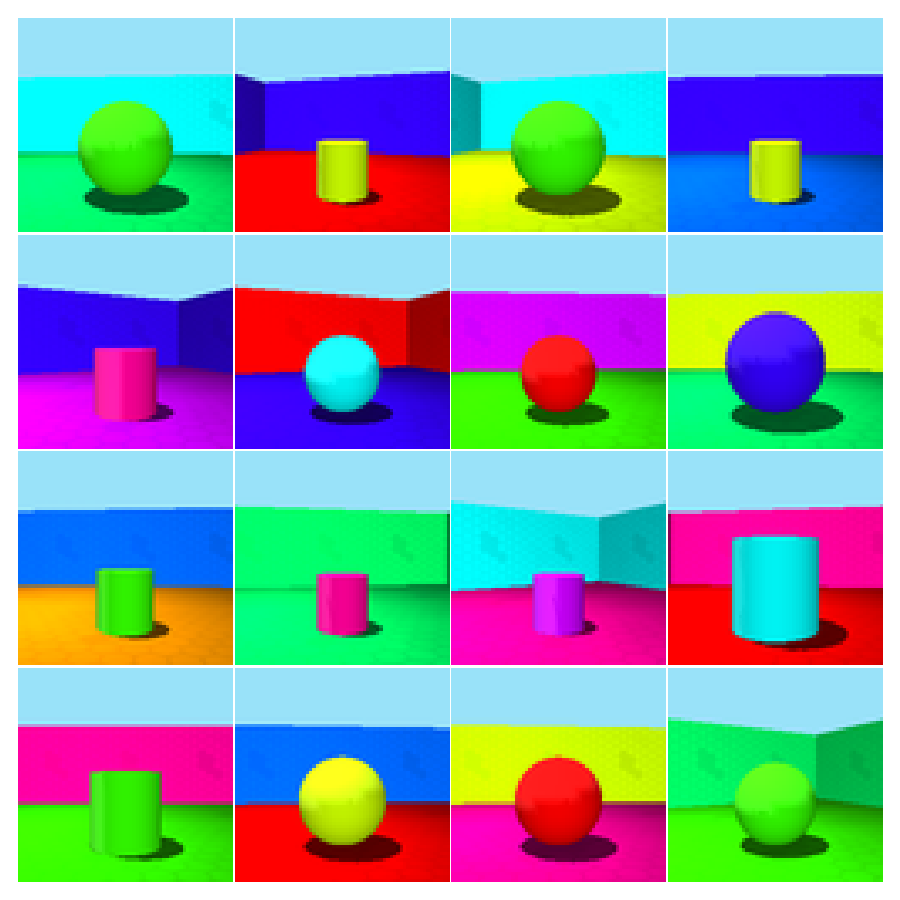

In [15]:
viz['original'][0].view(scale=2)

<IPython.core.display.Javascript object>


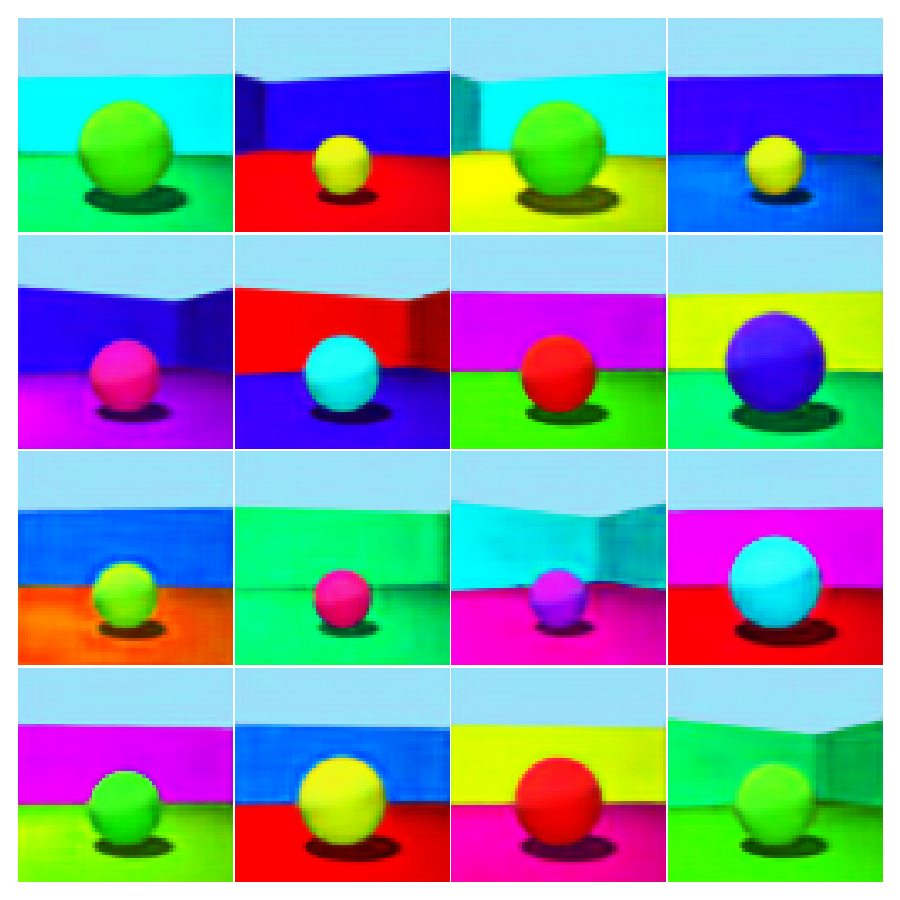

In [14]:
viz['recs'][0].view(scale=2)

In [43]:
A = S.A

In [44]:
model = S.model

In [45]:
dataset = S.dataset
len(dataset)

256

In [46]:
# loader = train.get_loaders(dataset, batch_size=16, num_workers=A.num_workers,
# 	                           shuffle=True, drop_last=False, )

Using batched data loader
